In [73]:
from scipy.linalg import toeplitz
from numpy import linalg as lin
from numpy import random
import matplotlib.pyplot as plt
import seaborn
import scipy as sp
import numpy as np
import pfaffian as pf
from numpy import ndarray

seaborn.set(context='notebook', style='darkgrid', palette='deep', font='serif', font_scale=2, color_codes=True, rc=None)

class hermitian(ndarray):    
    @property
    def hermitian_adjoint(self):
        return self.conj().T

## Just hand it the U-matrix and the eigenvalue matrix
## and plot_correlation_function returns and plots a correlation function.    
    
def plot_correlation_function(u, l0):
    No = 20
    jo = N//2
    Cxcor = np.zeros((2*No,2*No),dtype='complex')

    for i in range(0,2*No):
        for k in range(i+1,2*No):
            if np.mod(i+1,2)==1:
                if np.mod(k+1,2) == 0:
                    Cxcor[i,k] = BA((i+1-1)//2+jo,jo+(k+1)//2,u,l0)
                    Cxcor[k,i] = -Cxcor[i,k]
                else:
                    Cxcor[i,k] = -AA(jo+(i-1+1)//2,jo+(k-1+1)//2,u,l0)
                    Cxcor[k,i] = -Cxcor[i,k]                
            else:
                if np.mod(k+1,2) == 0:
                    Cxcor[i,k] = AA(jo+(i+1)//2,jo+(k+1)//2,u,l0)
                    Cxcor[k,i] = -Cxcor[i,k]
                else:
                    Cxcor[i,k] = -BA(jo+(i+1)//2,jo+k//2,u,l0)
                    Cxcor[k,i] = -Cxcor[i,k]
                
    Cxx = np.zeros(No)
    Cxx[0] = 1
    for i in range(1,No):
        Cxx[i] = np.real(pf.pfaffian_LTL(Cxcor[0:2*i,0:2*i]))
    
    plt.figure(figsize=(15,10))
    plt.plot(range(0,No),(Cxx),'r.')
    plt.title('Correlation Function $C^{xx}(n)$')
    plt.xlabel('Site (n)')
    plt.ylabel('Correlation')
    plt.show()
    
def fill_diagonal(matrix, value):
    for i in range(0,len(matrix),1):
        matrix[i][i] = value

def random_diagonal(matrix, w):
    for i in range(0,len(matrix),1):
        matrix[i][i] = ((np.random.rand()-1.0/2.0) * w)           
    
def alternate_diagonal(matrix):
    for i in range(0,len(matrix),1):
        if i % 2 == 0:
            matrix[i][i] *= -1
        else:
            pass

def fill_upper(matrix, value):
    for i in range(0,len(matrix)-1,1):
        if i % 2 == 0:
            matrix[i][i+1] = value
        elif i % 2 == 1:
            matrix[i][i+1] = value

def fill_lower(matrix, value):
    for i in range(0,len(matrix)-1,1):
        if i % 2 == 0:
            matrix[i+1][i] = value
        elif i % 2 == 1:
            matrix[i+1][i] = value

def solve(a): 
    return lin.eigh(a)

def AA(i,j,U,lam):
    a = 0.0
    for k in range(0,np.size(lam)):
        if lam[k]<=0:
            a = a + np.conj(U[i,k])*U[j,k]
        else:
            a = a + U[i,k]*np.conj(U[j,k])
    return a

def BA(i,j,U,lam):
    b = 0.0
    for k in range(0,np.size(lam)):
        if lam[k]<=0:
            b = b + np.conj(U[i,k])*U[j,k]
        else:
            b = b - U[i,k]*np.conj(U[j,k])
    return b

def hsolve(a): 
    return lin.eigh(a)

    # Diagonals are populated from the bottom up;
    # The first and last arguments represent the lowest and highest bands, respectively.
    # The rest of the diagonals are filled with zeroes.

def banded_matrix(size, a, b, c, d):
   
    row_one, row_two = [0],[0]
    row_one.append(b) 
    row_one.append(a) 
    row_two.append(c) 
    row_two.append(d) 
    for i in range(size-3): 
        row_one.append(0)
        row_two.append(0)
    return toeplitz(row_one, row_two)

def populate_density(eigenvalues, eigenvectors, density):
    for j in range(len(eigenvectors)):
        for k in range(len(eigenvalues)):
            if eigenvalues[k] <= 0:
                density[j] += eigenvectors[j, k] * np.conj(eigenvectors[j,k])
    return density

def populate_current(eigenvalues, eigenvectors, current, n):
    for j in range(len(eigenvectors)-1):
        for k in range(len(eigenvalues)):
            if eigenvalues[k] <= 0:
                current[j] += eigenvectors[j+n, k] * np.conj(eigenvectors[j,k])
    return current

In [74]:
def run(parameters):
    
    # Unpack parameter dict for ease-of-use.
    
    N, t, m = parameters['n'], parameters['t'], parameters['m']
    next_nearest_neighbor, nnn_amplitude = parameters['nnn'], parameters['nnn_a']
    scaling_factor, hopping_amplitude = parameters['sf'], parameters['ha']
    
    # Construct the hamiltonian matrix.
    
    hamiltonian_initial = banded_matrix(N,0.0,0.0,0.0,0.0)
    hamiltonian_final   = banded_matrix(N,nnn_amplitude*next_nearest_neighbor,0.0,0.0,nnn_amplitude*next_nearest_neighbor)
    fill_upper(hamiltonian_initial, hopping_amplitude*-0.5)
    fill_lower(hamiltonian_initial, hopping_amplitude*-0.5)
    for i in range(0,len(hamiltonian_initial),1):
            hamiltonian_initial[i][i] = scaling_factor * (float(i * 1.0) - 0.5 * N)
    fill_diagonal(hamiltonian_final, m)
    alternate_diagonal(hamiltonian_final)
    fill_upper(hamiltonian_final, hopping_amplitude*-0.5)
    fill_lower(hamiltonian_final, hopping_amplitude*-0.5)
    eigenvalues, eigenvectors = solve(hamiltonian_initial)
    eigenvalues_final, eigenvectors_final = solve(hamiltonian_final)
    D = banded_matrix(N,complex(0.0),complex(0.0),complex(0.0),complex(0.0))

    for i in range(0,len(D),1):
        D[i][i] = np.exp(-1j * eigenvalues_final[i] * t, casting = 'same_kind') 

    U = np.asmatrix(eigenvectors_final) * np.asmatrix(D) * np.asmatrix(eigenvectors_final).getH() * np.asmatrix(eigenvectors)

    density = populate_density(eigenvalues, eigenvectors, np.zeros(len(eigenvectors), dtype = 'complex'))
    density_final = populate_density(eigenvalues, np.asmatrix(U), np.zeros(len(eigenvectors_final), dtype = 'complex'))
    
    # Computing the correlation function:
    u, l0 = U, eigenvalues
    No = 20
    jo = N//2
    Cxcor = np.zeros((2*No,2*No),dtype='complex')

    for i in range(0,2*No):
        for k in range(i+1,2*No):
            if np.mod(i+1,2)==1:
                if np.mod(k+1,2) == 0:
                    Cxcor[i,k] = BA((i+1-1)//2+jo,jo+(k+1)//2,u,l0)
                    Cxcor[k,i] = -Cxcor[i,k]
                else:
                    Cxcor[i,k] = -AA(jo+(i-1+1)//2,jo+(k-1+1)//2,u,l0)
                    Cxcor[k,i] = -Cxcor[i,k]                
            else:
                if np.mod(k+1,2) == 0:
                    Cxcor[i,k] = AA(jo+(i+1)//2,jo+(k+1)//2,u,l0)
                    Cxcor[k,i] = -Cxcor[i,k]
                else:
                    Cxcor[i,k] = -BA(jo+(i+1)//2,jo+k//2,u,l0)
                    Cxcor[k,i] = -Cxcor[i,k]
                
    Cxx = np.zeros(No)
    Cxx[0] = 1
    for i in range(1,No):
        Cxx[i] = np.real(pf.pfaffian_LTL(Cxcor[0:2*i,0:2*i]))
        
    return density, density_final, Cxx

In [75]:
# Simulation parameters:
# 'n': number of sites (int)
# 't': time steps (int)
# 'm': tuning parameter (float)
# 'nnn': next-nearest-neighbor interactions (boolean)
# 'nnn_a': next-nearest-neighbor amplitudes (float)
# 'sf': scaling factor (float)
# 'ha': hopping amplitude (float)


In [76]:
params_1 = {
    'n': 1000,
    't': 500 ,
    'm': 0.5 ,
    'nnn' : 0,
    'nnn_a' : 0,  
    'sf' : 0.3,
    'ha' : 1.0,
}

density_1, density_final_1, correlation_1 =  run(params_1)

/home/joseph/libs/Anaconda/lib/python3.5/site-packages/numpy/core/numeric.py:501: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


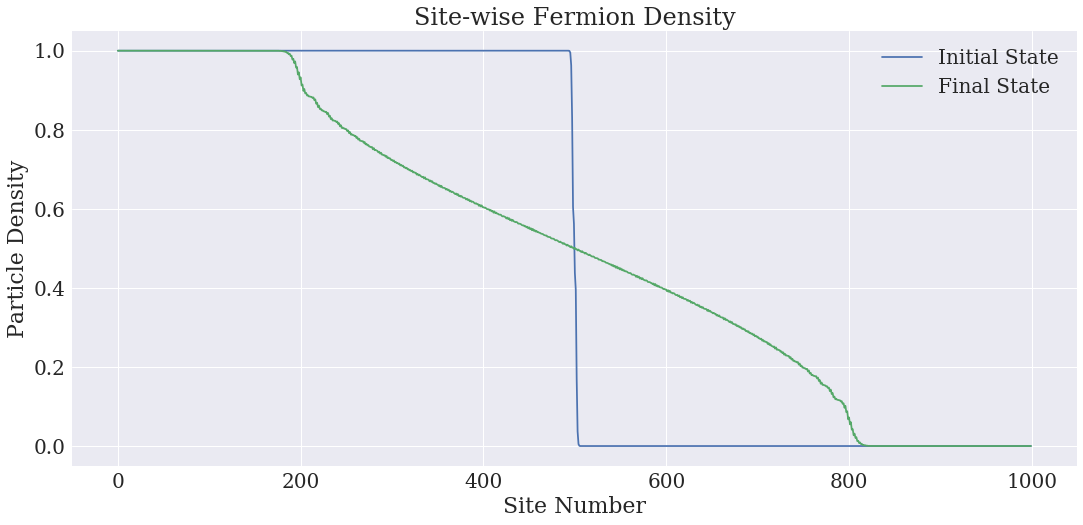

In [77]:
plt.figure(figsize=(18,8))
plt.title("Site-wise Fermion Density")
plt.plot(density_1, label='Initial State')
plt.plot(density_final_1, label='Final State')
plt.xlabel("Site Number")
plt.ylabel("Particle Density")
plt.legend()
plt.show()

Text(0,0.5,'Normalized Correlation')

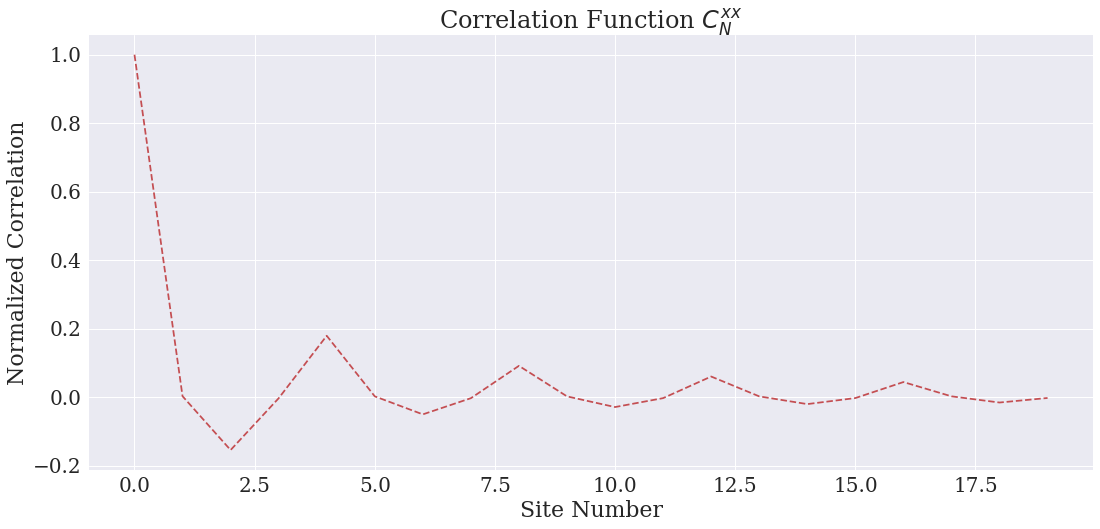

In [87]:
plt.figure(figsize=(18,8))
plt.title("Correlation Function $C^{xx}_N$")
plt.plot(correlation_1, 'r--')
plt.xlabel("Site Number")
plt.ylabel("Normalized Correlation")